In [1]:
 %load_ext autoreload
%autoreload 2
import networkx as nx
import numpy as np
import csv
from hydra import compose, initialize
from hydra.utils import instantiate
from hydra.core.global_hydra import GlobalHydra  # Import GlobalHydra explicitly
from topobench.utils.config_resolvers import (
    get_default_transform,
    get_monitor_metric,
    get_monitor_mode,
    infer_in_channels,
)

# Clear GlobalHydra instance if already initialized
if GlobalHydra().is_initialized():
    GlobalHydra().clear()

initialize(config_path="../configs", job_name="job")

/tmp/ipykernel_1785294/1368399653.py:20: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../configs", job_name="job")


hydra.initialize()

In [25]:
cfg = compose(
    config_name="run.yaml",
    overrides=[
        "model=graph/gat",
        "dataset=graph/FTD",
        "dataset.loader.parameters.adj_thresh=0.5",
    ], 
    return_hydra_config=True
)
loader = instantiate(cfg.dataset.loader)
all_dataset, dataset_dir = loader.load()
ftd_dataset = loader.datasets[0]

def load_dataset(adj_thresh=0.5):
    """
    Load the FTD dataset with a specified adjacency threshold.
    """
    cfg = compose(
        config_name="run.yaml",
        overrides=[
            "model=graph/gat",
            "dataset=graph/FTD",
            f"dataset.loader.parameters.adj_thresh={adj_thresh}",
        ], 
        return_hydra_config=True
    )
    loader = instantiate(cfg.dataset.loader)
    _, _ = loader.load()
    return loader.datasets[0]

Processed file names: ['ftd_y_val_nfl_adj_thresh_0.5_num_nodes_7287_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_train_random_state_42.pt', 'ftd_y_val_nfl_adj_thresh_0.5_num_nodes_7287_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_val_random_state_42.pt']
Loading data from: /scratch/lcornelis/data/data_louisa/processed/ftd_y_val_nfl_adj_thresh_0.5_num_nodes_7287_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_train_random_state_42.pt
Processed file names: ['ftd_y_val_nfl_adj_thresh_0.5_num_nodes_7287_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_train_random_state_42.pt', 'ftd_y_val_nfl_adj_thresh_0.5_num_nodes_7287_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_val_random_state_42.pt']
Loading data from: /scratch/lcornelis/data/data_louisa/processed/ftd_y_val_nfl_adj_thresh_0.5_num_nodes_7287_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_val_random_state_42.pt
Processed file names: ['ftd_y_val_nfl_adj_thresh_0.5_num_nodes_7287_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_train_random_state_42.pt', 'ftd_y_val_nfl_

In [3]:
adj_matrix = ftd_dataset.load_adjacency_matrix(
                ftd_dataset.adj_path, ftd_dataset.config.adj_thresh, ftd_dataset.config
            )

Loading adjacency matrix from: /scratch/lcornelis/data/data_louisa/processed/adjacency_num_nodes_7287_mutation_['GRN', 'MAPT', 'C9orf72', 'CTL']_csf_sex_['M', 'F'].csv...
Adjacency matrix shape: torch.Size([7287, 7287])
Number of edges: tensor(44507.)


In [4]:
adj_matrix

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [23]:
def get_graph_stats(ftd_dataset):
    """
    Get statistics of the graph.
    """
    # Load the adjacency matrix
    adj_matrix = ftd_dataset.load_adjacency_matrix(ftd_dataset.adj_path, ftd_dataset.config.adj_thresh, ftd_dataset.config)
    # Generate a graph from the adjacency matrix
    graph = nx.from_numpy_matrix(adj_matrix.cpu().numpy())
    graph.remove_edges_from(nx.selfloop_edges(graph))
    
    # Calculate statistics
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    avg_degree = np.mean([d for n, d in graph.degree()])
    density = nx.density(graph)
    number_connected_components = nx.number_connected_components(graph)
    
    return {
        "num_nodes": num_nodes,
        "num_edges": num_edges,
        "avg_degree": avg_degree,
        "density": density,
        "number_connected_components": number_connected_components,
    }
    

# Get graph statistics
stats = get_graph_stats(ftd_dataset)
print("\nGraph statistics:\n")
for key, value in stats.items():
    print(f"\t{key}: {value}")

Loading adjacency matrix from: /scratch/lcornelis/data/data_louisa/processed/adjacency_num_nodes_7287_mutation_['GRN', 'MAPT', 'C9orf72', 'CTL']_csf_sex_['M', 'F'].csv...
Adjacency matrix shape: torch.Size([7287, 7287])
Number of edges: tensor(44507.)

Graph statistics:

	num_nodes: 7287
	num_edges: 18610
	avg_degree: 5.107726087553177
	density: 0.0007010329519013419
	number_connected_components: 5883


In [ ]:
import csv

# Initialize a list to store all stats
all_stats = []

for adj_thresh in np.arange(0, 1.01, 0.01):
    # Load the dataset
    ftd_dataset = load_dataset(adj_thresh=adj_thresh)
    # Get graph statistics
    stats = get_graph_stats(ftd_dataset)
    # Add the adjacency threshold to the stats
    stats["adj_thresh"] = adj_thresh
    # Append the stats to the list
    all_stats.append(stats)
    
# Save all stats to a CSV file
output_file = "./stats/graph_stats.csv"
with open(output_file, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["adj_thresh", "num_nodes", "num_edges", "avg_degree", "density", "number_connected_components"])
    writer.writeheader()  # Write the header row
    writer.writerows(all_stats)  # Write all rows

print(f"Graph statistics saved to {output_file}")

Processed file names: ['ftd_y_val_nfl_adj_thresh_0.25_num_nodes_7287_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_train_random_state_42.pt', 'ftd_y_val_nfl_adj_thresh_0.25_num_nodes_7287_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_val_random_state_42.pt']
Loading data from: /scratch/lcornelis/data/data_louisa/processed/ftd_y_val_nfl_adj_thresh_0.25_num_nodes_7287_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_train_random_state_42.pt
Processed file names: ['ftd_y_val_nfl_adj_thresh_0.25_num_nodes_7287_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_train_random_state_42.pt', 'ftd_y_val_nfl_adj_thresh_0.25_num_nodes_7287_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_val_random_state_42.pt']
Loading data from: /scratch/lcornelis/data/data_louisa/processed/ftd_y_val_nfl_adj_thresh_0.25_num_nodes_7287_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_val_random_state_42.pt
Processed file names: ['ftd_y_val_nfl_adj_thresh_0.25_num_nodes_7287_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_train_random_state_42.pt', 'ftd_y_v

In [39]:
for i in range(100, -1, -1):
    print(i/100)

1.0
0.99
0.98
0.97
0.96
0.95
0.94
0.93
0.92
0.91
0.9
0.89
0.88
0.87
0.86
0.85
0.84
0.83
0.82
0.81
0.8
0.79
0.78
0.77
0.76
0.75
0.74
0.73
0.72
0.71
0.7
0.69
0.68
0.67
0.66
0.65
0.64
0.63
0.62
0.61
0.6
0.59
0.58
0.57
0.56
0.55
0.54
0.53
0.52
0.51
0.5
0.49
0.48
0.47
0.46
0.45
0.44
0.43
0.42
0.41
0.4
0.39
0.38
0.37
0.36
0.35
0.34
0.33
0.32
0.31
0.3
0.29
0.28
0.27
0.26
0.25
0.24
0.23
0.22
0.21
0.2
0.19
0.18
0.17
0.16
0.15
0.14
0.13
0.12
0.11
0.1
0.09
0.08
0.07
0.06
0.05
0.04
0.03
0.02
0.01
0.0


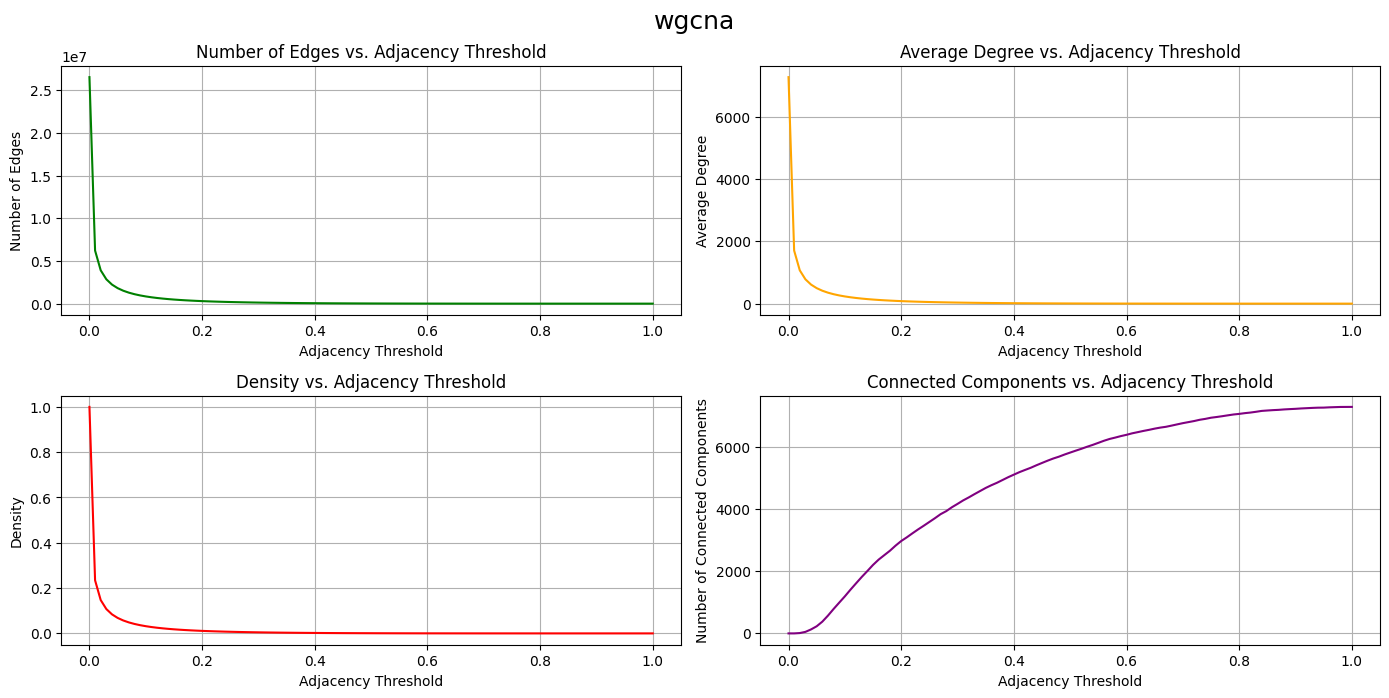

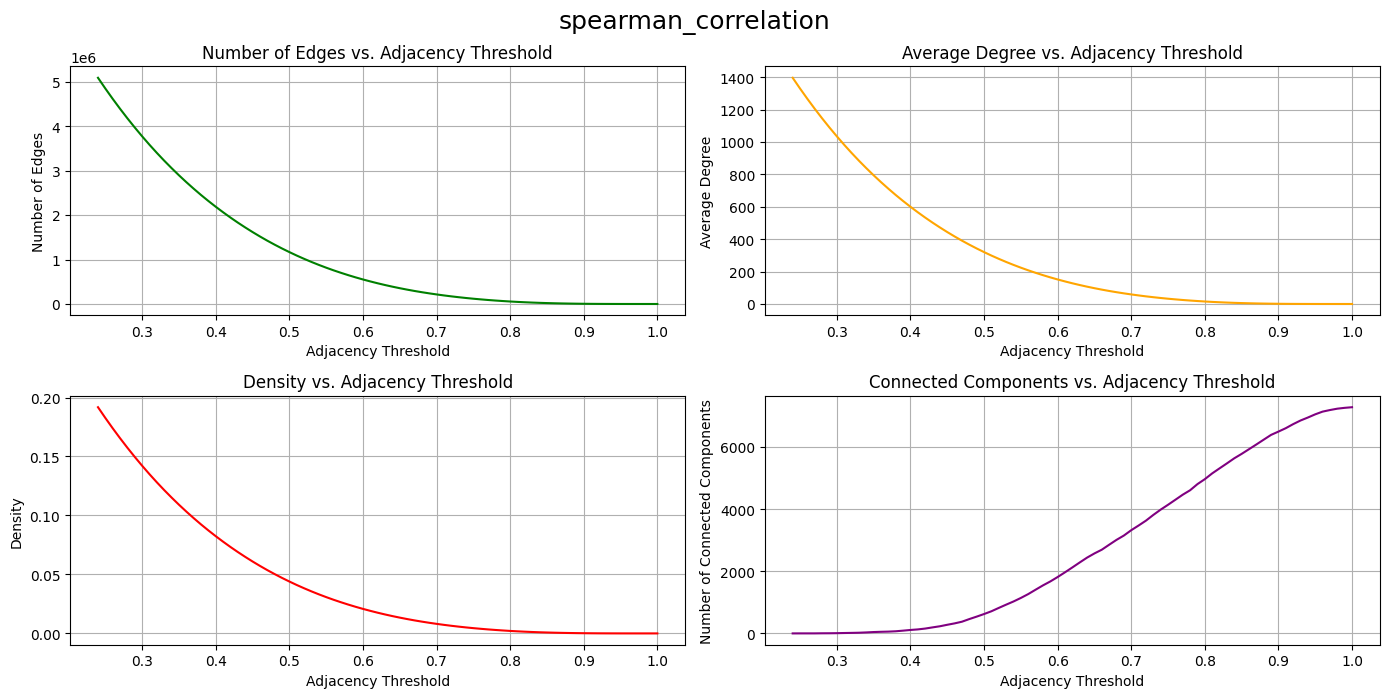

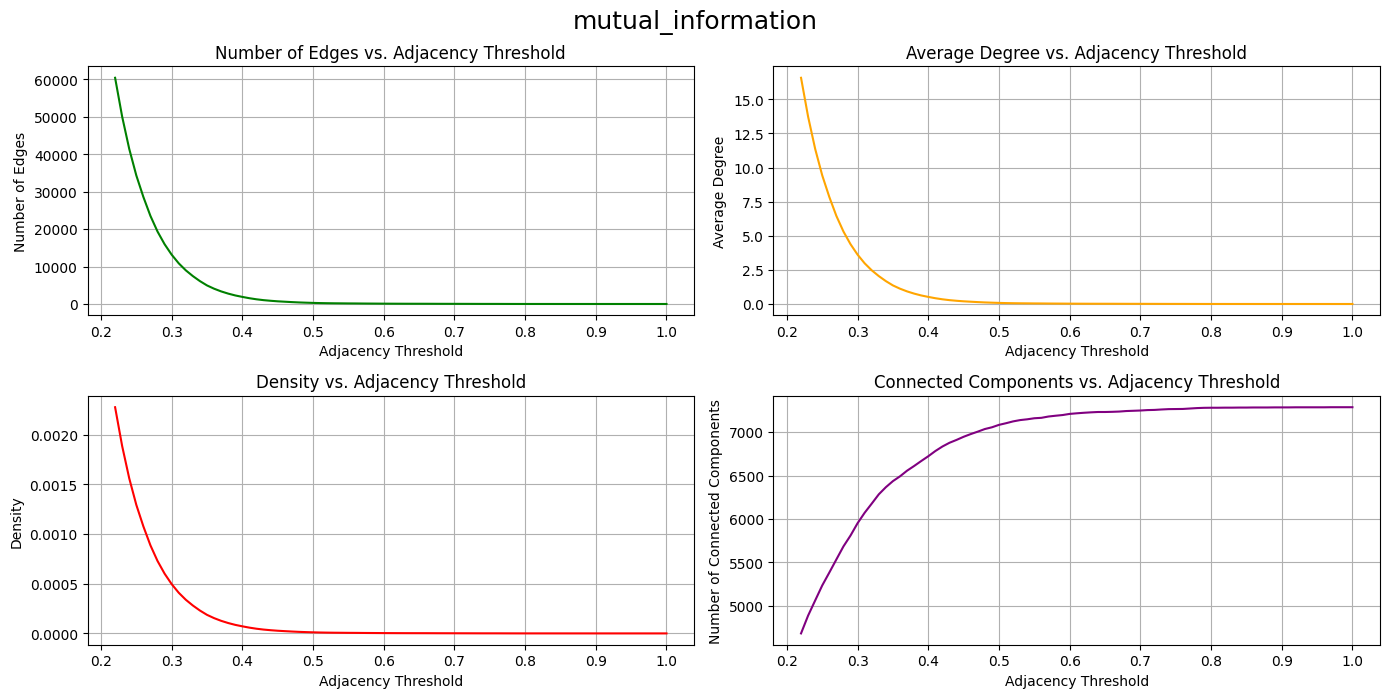

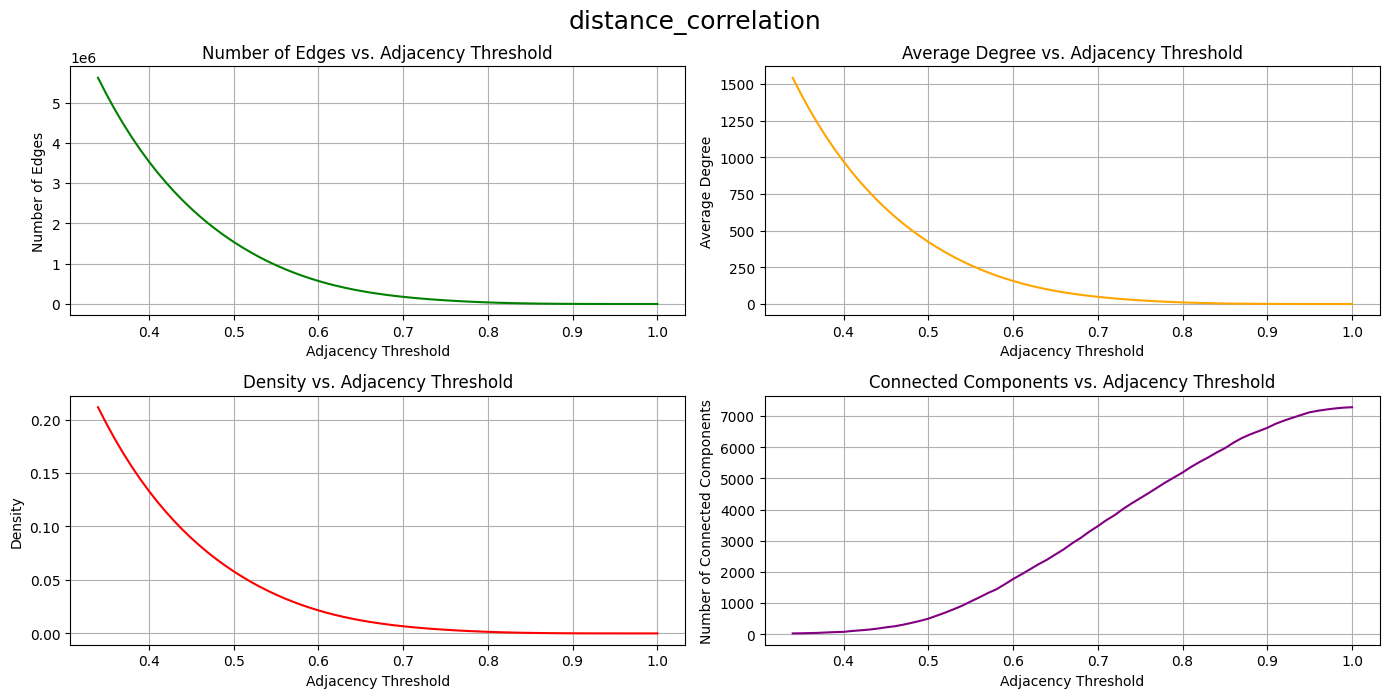

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

metrics = ["wgcna", "spearman_correlation", "mutual_information", "distance_correlation"]

for metric in metrics:
    # Load the CSV file into a pandas DataFrame
    csv_file = "./stats/"+metric+"/graph_stats.csv"
    df = pd.read_csv(csv_file)
    # Sort the DataFrame by the 'adj_thresh' column in ascending order
    df = df.sort_values(by="adj_thresh", ascending=True)

    # Plot the evolution of graph statistics with respect to adj_thresh
    plt.figure(figsize=(14, 10))
    plt.suptitle(metric, fontsize=18)

    # Plot number of edges
    plt.subplot(3, 2, 1)
    plt.plot(df["adj_thresh"], df["num_edges"], label="Number of Edges", color="green")
    plt.xlabel("Adjacency Threshold")
    plt.ylabel("Number of Edges")
    plt.title("Number of Edges vs. Adjacency Threshold")
    plt.grid(True)

    # Plot average degree
    plt.subplot(3, 2, 2)
    plt.plot(df["adj_thresh"], df["avg_degree"], label="Average Degree", color="orange")
    plt.xlabel("Adjacency Threshold")
    plt.ylabel("Average Degree")
    plt.title("Average Degree vs. Adjacency Threshold")
    plt.grid(True)

    # Plot density
    plt.subplot(3, 2, 3)
    plt.plot(df["adj_thresh"], df["density"], label="Density", color="red")
    plt.xlabel("Adjacency Threshold")
    plt.ylabel("Density")
    plt.title("Density vs. Adjacency Threshold")
    plt.grid(True)

    # Plot number of connected components
    plt.subplot(3, 2, 4)
    plt.plot(df["adj_thresh"], df["number_connected_components"], label="Connected Components", color="purple")
    plt.xlabel("Adjacency Threshold")
    plt.ylabel("Number of Connected Components")
    plt.title("Connected Components vs. Adjacency Threshold")
    plt.grid(True)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

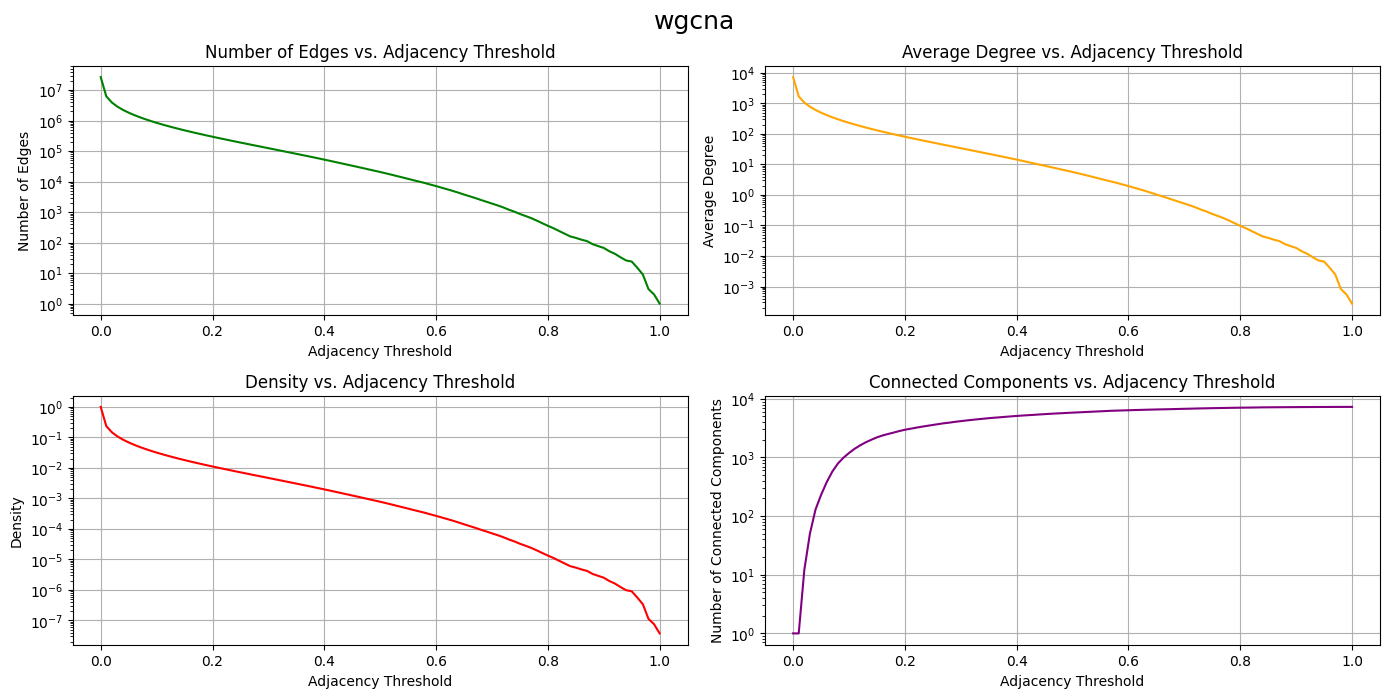

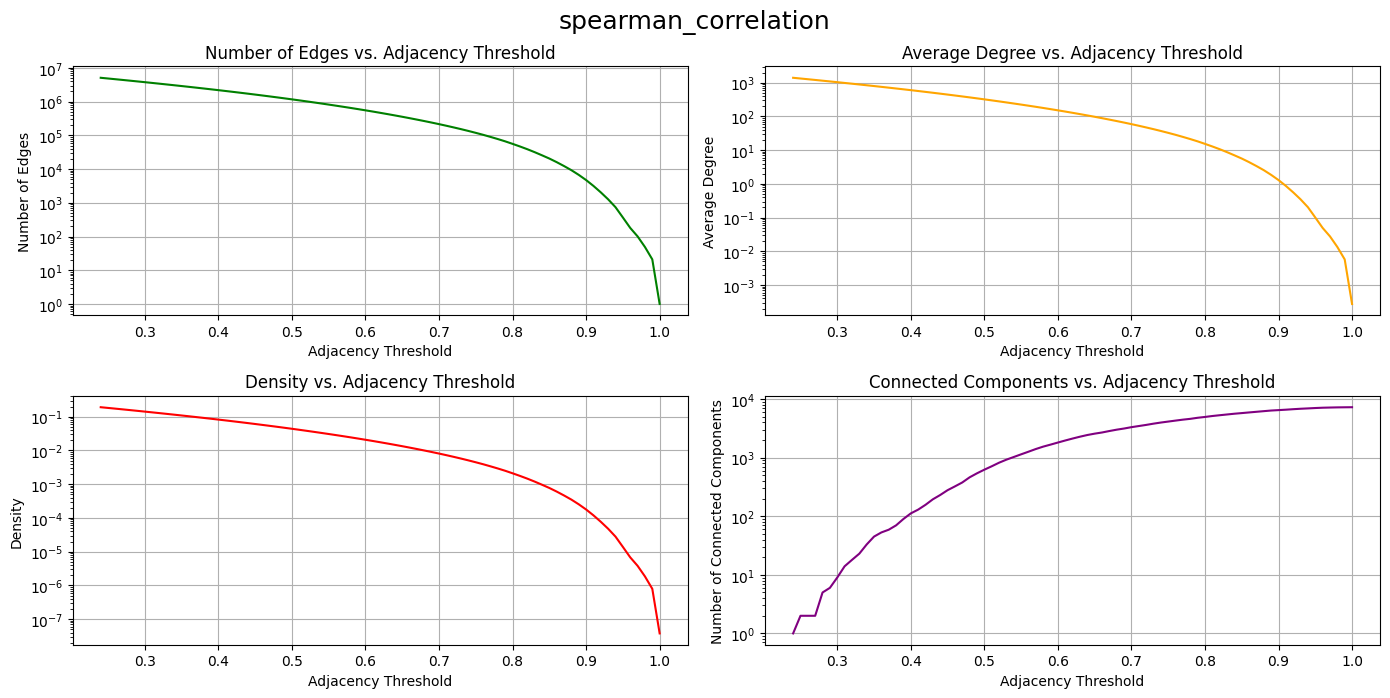

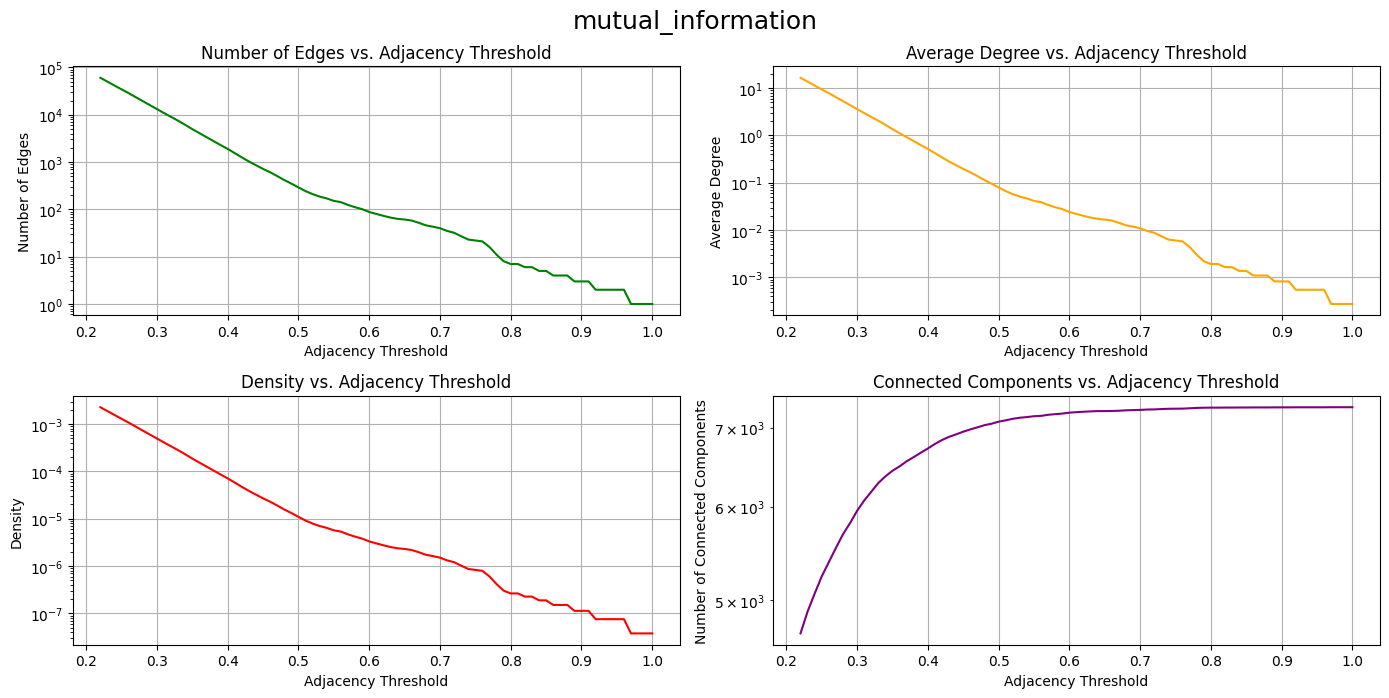

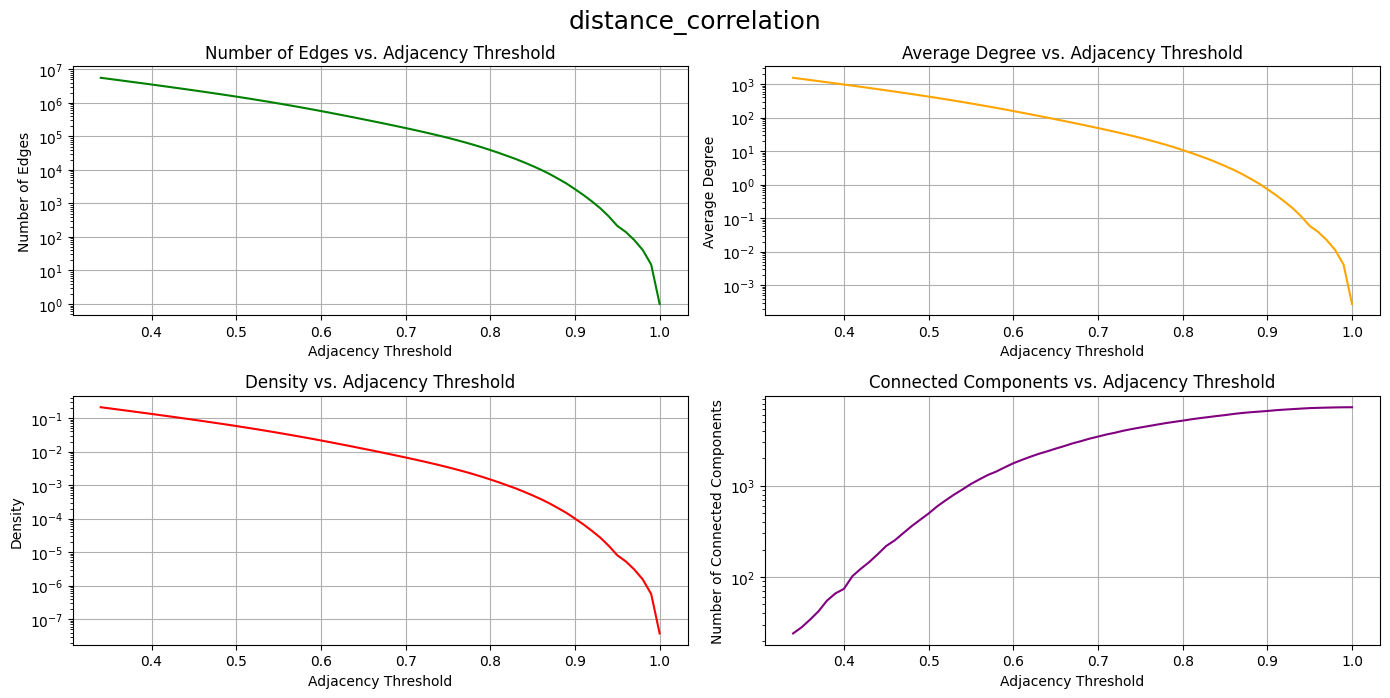

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

metrics = ["wgcna", "spearman_correlation", "mutual_information", "distance_correlation"]

for metric in metrics:
    # Load the CSV file into a pandas DataFrame
    csv_file = "./stats/"+metric+"/graph_stats.csv"
    df = pd.read_csv(csv_file)
    # Sort the DataFrame by the 'adj_thresh' column in ascending order
    df = df.sort_values(by="adj_thresh", ascending=True)

    # Plot the evolution of graph statistics with respect to adj_thresh
    plt.figure(figsize=(14, 10))
    plt.suptitle(metric, fontsize=18)

    # Plot number of edges
    plt.subplot(3, 2, 1)
    plt.plot(df["adj_thresh"], df["num_edges"], label="Number of Edges", color="green")
    plt.xlabel("Adjacency Threshold")
    plt.ylabel("Number of Edges")
    plt.title("Number of Edges vs. Adjacency Threshold")
    plt.yscale("log")  # Set y-axis to logarithmic scale
    plt.grid(True)

    # Plot average degree
    plt.subplot(3, 2, 2)
    plt.plot(df["adj_thresh"], df["avg_degree"], label="Average Degree", color="orange")
    plt.xlabel("Adjacency Threshold")
    plt.ylabel("Average Degree")
    plt.title("Average Degree vs. Adjacency Threshold")
    plt.yscale("log")  # Set y-axis to logarithmic scale
    plt.grid(True)

    # Plot density
    plt.subplot(3, 2, 3)
    plt.plot(df["adj_thresh"], df["density"], label="Density", color="red")
    plt.xlabel("Adjacency Threshold")
    plt.ylabel("Density")
    plt.title("Density vs. Adjacency Threshold")
    plt.yscale("log")  # Set y-axis to logarithmic scale
    plt.grid(True)

    # Plot number of connected components
    plt.subplot(3, 2, 4)
    plt.plot(df["adj_thresh"], df["number_connected_components"], label="Connected Components", color="purple")
    plt.xlabel("Adjacency Threshold")
    plt.ylabel("Number of Connected Components")
    plt.title("Connected Components vs. Adjacency Threshold")
    plt.yscale("log")  # Set y-axis to logarithmic scale
    plt.grid(True)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()
    plt.close()